## Telecom churn case study 

    - Using multivariant logistic regression 
    - Datasets are available in Datasets folder

### Steps:
 - Data cleaning and preparation
        - Combining three dataframes
        - Handling categorical variables
            - Mapping categorical variables to integers
            - Dummy variable creation
        - Handling missing values
 - Test-train split and scaling
 - Model Building
        - Feature elimination based on correlations
        - Feature selection using RFE (Coarse Tuning)
        - Manual feature elimination (using p-values and VIFs)
 - Model Evaluation
        - Accuracy
        - Sensitivity and Specificity
        - Optimal cut-off using ROC curve
        - Precision and Recall
 - Predictions on the test set

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import required libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data cleaning and preparation

### Combining three dataframes

- Dataset 1 - Churn Data

In [3]:
churn_data = pd.read_csv('datasets/churn_data.csv')

In [4]:
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


- Dataset 2 - custmomer data

In [5]:
customer_data = pd.read_csv('datasets/customer_data.csv')

In [6]:
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


- Dataset 3 - Internet Data

In [7]:
internet_data = pd.read_csv('datasets/internet_data.csv')

In [8]:
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


#### Summary
    - Customer ID is common key between all three datasets
    - Chrun_data - It has target varibale along with other variables.
    - Customer_data - It has few details about customers, like Gender, Senior Citizen , dependents etc.
    - Internrt_data - It has all options or services customer is using.

In [9]:
# Merge all datasets to create final single dataset with all required information.
tmp_df1 = pd.merge(churn_data, customer_data, how='inner', on = 'customerID')

In [10]:
tmp_df1.head() 

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No


In [11]:
telecom = pd.merge(tmp_df1, internet_data, how='inner', on='customerID')

In [12]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


- telecom dataframe is consolidated dataframe with all required information.

### Inspecting merged datafram

In [13]:
telecom.shape  #It has 7043 data points with 21 features including target variable.

(7043, 21)

In [14]:
#Lets check the statistical summary of dataset.
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


- This show statistical summary of 3 columns only, as out of 21 columns, only three columns are numeric in nature. And, we know statstic work on numerical varibales only not on categorical variable.  

In [15]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


- Info shows same,i.e, tenure,  MonthlyCharges and SeniorCitizen columns are numeric.
- Also, there are no columns with null value. 

#### Data Preparation 
- Converting columns with Yes/No to 1/0 

In [16]:
#Get columns with only Yes and No as values
pd.options.display.max_columns = None
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [17]:
telecom.nunique(axis=0)

customerID          7043
tenure                73
PhoneService           2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
dtype: int64

In [18]:
#Columns with just Yes/No values
col_names = ['PhoneService','PaperlessBilling','Churn','Partner','Dependents']

- Use lambda function to convert all Yes to 1 and No to 0
- Here we have not taken Senior Citizen as it is already in numeric form and Gender is Male/Female and not Yes/No

In [19]:
telecom[col_names] = telecom[col_names].apply(lambda x : x.map({'Yes': 1, 'No': 0}))

In [20]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,0,0,0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,0,0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,0,0,No,Fiber optic,No,No,No,No,No,No


In [21]:
telecom.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [22]:
telecom.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [23]:
telecom.TechSupport.value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

- For other categorical columns there are multiple values. 
- Hence, we will be using **Dummy Variable** method to convert categorical into Numeric

- Focus on features which has Dtypes as objects.
- Excluding feature TotalCharges for now, it should be continuos.

In [24]:
# list of features 
dummy_1 = ['Contract','PaymentMethod','InternetService','gender','MultipleLines','OnlineSecurity','OnlineBackup',
           'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

- Writing a function to convert categorical features into numeric using get_dummies 
- Also, by not dropping first column, instead column with longest length of its name

In [25]:
def dummies_drop_maxlen_col(lst : list, df) :
    """
    ****Prashik Bansod******
    Two arguments :
        1. List of columns names
        2. Pandas dataframe
    return : A dataframe with dummy variables without longest column name
    """
    for i in lst:
        i_tmp = pd.get_dummies(df[i],prefix=i)
        final_nm = {}
        for col_nm in i_tmp.columns:
            final_nm[col_nm] = len(col_nm)
        to_drop = max(final_nm, key=lambda x : final_nm[x])
        i_tmp = i_tmp.drop([to_drop], axis = 1)
        df = pd.concat([df,i_tmp], axis=1)
    return df
        

In [26]:
telecom = dummies_drop_maxlen_col(dummy_1, telecom)

In [27]:
telecom.head(2)

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_No,gender_Male,MultipleLines_No,MultipleLines_Yes,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,0,0,0,No,DSL,Yes,No,Yes,No,No,No,1,0,0,0,1,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0


In [28]:
# Drop features which we converted using get_dummies

In [29]:
telecom = telecom.drop(dummy_1, axis=1)

In [30]:
telecom.head(2)

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_No,gender_Male,MultipleLines_No,MultipleLines_Yes,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,1,29.85,29.85,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,34,1,0,56.95,1889.5,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0


In [31]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7043 non-null   object 
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

- Here we see 2 columns are still of type object:
    - customerID : not required as a feature for model. It is more of as an unique identifier 
    - TotalCharges : This should be continuos, lets impect this columns and change it to float

In [32]:
# pd.to_numeric(telecom.TotalCharges) -> using this we saw at index 488, it has empty string with one space.
## replacing it with 0 
telecom['TotalCharges'] = telecom['TotalCharges'].replace(' ',0)

In [33]:
#COnvert Dtype to numeric
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'])

In [34]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7043 non-null   float64
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

### Check outliers in continuous features

In [35]:
con_feat = ['tenure','MonthlyCharges','TotalCharges']

In [36]:
#Create tmp dataframe to check outliers 
tmp_df = telecom[con_feat]

In [37]:
tmp_df.head(2)

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50


In [38]:
tmp_df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


<AxesSubplot:>

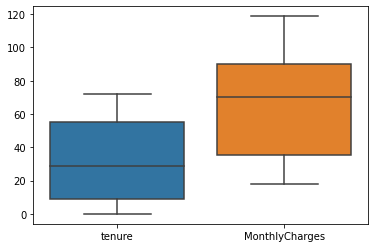

In [39]:
sns.boxplot(data=tmp_df[['tenure','MonthlyCharges']])

<AxesSubplot:xlabel='TotalCharges'>

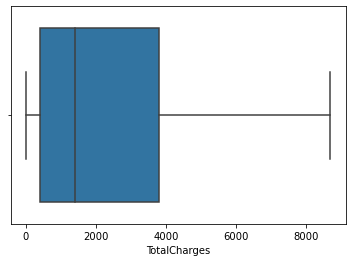

In [40]:
sns.boxplot(tmp_df.TotalCharges)

- We dont see any outliers

In [41]:
#### Handling null values 

In [42]:
telecom.isnull().sum()

customerID                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
Contract_One year                        0
Contract_Two year                        0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
InternetService_DSL                      0
InternetService_No                       0
gender_Male                              0
MultipleLines_No                         0
MultipleLines_Yes                        0
OnlineSecurity_No                        0
OnlineSecurity_Yes                       0
OnlineBackup_No                          0
OnlineBacku

### Train Test Split

In [ ]:
#Creating feature variables 
X = telecom.drop(['Churn','customerID'], axis=1)

In [ ]:
#Creating target varible
y = telecom['Churn']

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
#Split data into train and test
X_train,X_test,y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=100)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
telecom.shape

#### Feature Scaling

In [ ]:
#Using MinMaxScalar class 
# creating object
scalar = MinMaxScaler()

In [ ]:
#Standardizing the continuos columns of train dataset
con_feat

In [ ]:
X_train[con_feat] = scalar.fit_transform(X_train[con_feat])

In [ ]:
X_train.head()

In [ ]:
X_train[con_feat].describe()

#### Data imbalance

In [ ]:
telecom.Churn.sum()

In [ ]:
len(telecom.Churn.index)

In [ ]:
round((telecom.Churn.sum()/len(telecom.Churn.index))*100)

- 27% is a churn Rate.

### Looking at Correlations
- among all the features

In [ ]:
#Using heatmap
plt.figure(figsize=(20,10))
sns.heatmap(telecom.corr(), annot=True)
plt.show()

In [ ]:
#Listing down highly correalated variables
corr_vars = ['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
             'StreamingTV_No','StreamingMovies_No']

In [ ]:
sns.heatmap(telecom[corr_vars].corr(), annot=True)

In [ ]:
#Dropping correlated features
X_train = X_train.drop(corr_vars, axis=1)
X_test = X_test.drop(corr_vars, axis=1)

In [ ]:
X_train.info()

In [ ]:
### For Review, check the correlation between similar dummy variables like between Yes_No

In [ ]:
new_lst=[]
for x in telecom.columns:
    try:
        if x.split('_')[1] in ('Yes','No'):
            new_lst.append(x)
    except IndexError:
        pass

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(telecom[new_lst].corr(), annot=True)

- Here we can see all the similar yes_no pairs are highly correlated. Correlation is negative.
- Eg: MultipleLines_Yes and MultipleLines_No has correlation as -0.82. viz. high. Business perspective, customer can take Multiple lines or not take multiple lines, hence it is inversly related.

### Model Training 
- We will be using statsmodel as we need to see the statistics of model also, unlike sklearn Logistic Regression

In [ ]:
import statsmodels.api as sm

In [ ]:
def build_statsmodel(train_X,train_y):
    """
    Function to take features dataframe and target data frame and returns model as output using statsmodel
    """
    X_train_sm = sm.add_constant(train_X)
    model = sm.GLM(train_y, X_train_sm, family=sm.families.Binomial())
    model = model.fit()
    return model, X_train_sm

In [ ]:
model_1, X_train_sm = build_statsmodel(X_train, y_train)

In [ ]:
print(model_1.summary())

- Observations on Features for modelling
    1. Considering the P-values, there are many features which are still insignificant. 
    2. Some of the coefficient are negative, which is fine.
- Therefore, we have to further eleminate insignificant features.
    1. First by using Automated approach,i.e. **RFE (Recursive Feature Elimination )** - Top 15 Features
    2. Manual approach

### Feature selection using RFE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [ ]:
logreg = LogisticRegression()

In [ ]:
rfe = RFE(logreg, 15) 
#Creating a rfe variable with object of Logistic Regression and passing 15 features to choose 

In [ ]:
#fit training dataset
rfe = rfe.fit(X_train, y_train)

In [ ]:
rfe.support_

In [ ]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
#As we have asked RFE to choose 15 features, we can see 15 values as TRUE

In [ ]:
cols = X_train.columns[rfe.support_]

In [ ]:
cols

In [ ]:
len(cols)

In [ ]:
X_train_rfe = X_train[cols]

In [ ]:
X_train_rfe.head()

In [ ]:
rfe_model, rfe_train_sm = build_statsmodel(X_train_rfe, y_train)

In [ ]:
print(rfe_model.summary())

- **Observation** :
    - By looking at P values of all features selected by RFE, all features seems to be significant

In [ ]:
#### Predict the target using this model 
y_train_pred = rfe_model.predict(rfe_train_sm)

In [ ]:
y_train_pred[0:10]

In [ ]:
y_train_pred = y_train_pred.values.reshape(-1)

In [ ]:
y_train_pred.shape

In [ ]:
### Creating new dataframe with actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_prob': y_train_pred, 'CustID':y_train.index})

In [ ]:
y_train_pred_final.head()

In [ ]:
# Now lets take threshold as 0.5, so if pred probability is greater than 0.5 Churn is 1 else 0 
y_train_pred_final['predicted'] = y_train_pred_final.Churn_prob.apply(lambda x : 1 if x > 0.5 else 0)

In [ ]:
y_train_pred_final.head(20)

In [ ]:
y_train_pred_final.predicted.value_counts()

In [ ]:
y_train_pred_final.Churn.value_counts()

- Here we have choosen threshold as 0.5 at random. The predicted values definitly will have some errors, like:
    - 'Churn' customers are predicted as 'Non-Churn'
    - 'Non-Churn' customers are predicted as 'Churn'

- Lets use some of the metrics to see model performace 
    - The simplest model evaluation metric for classification models is **accuracy** - it is the percentage of correctly predicted labels
    - **Accuracy** = (Correctly predicted labels)/(Total number of labels)

In [ ]:
len(y_train_pred_final[y_train_pred_final.Churn == y_train_pred_final.predicted])

In [ ]:
len(y_train_pred_final)

In [ ]:
4010/4930

In [ ]:
from sklearn import metrics

In [ ]:
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted)

In [ ]:
confusion

In [ ]:
#predicated     non-churn     churn
#actuals
#non-churn        3259         368
#churn            552         751

In [ ]:
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

### Manual feature elimination
- RFE has given 15 features. There are high value of correlations present between 15 features, i.e, there is still come multicollinearity among the features
- Lets use VIF - Variation infaltion factor, to eliminate redundant features

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF',ascending=False)
    return vif

In [ ]:
calculate_vif(X_train_rfe)

- VIF of feature 'MonthlyCharges' is too high, hence dropping

In [ ]:
X_train_rfe = X_train_rfe.drop('MonthlyCharges', axis=1) 

In [ ]:
X_train_rfe.columns

In [ ]:
#rebuild the model 
model_2, df = build_statsmodel(X_train_rfe, y_train)

In [ ]:
print(model_2.summary())

In [ ]:
y_train_pred = model_2.predict(df).values.reshape(-1)

In [ ]:
y_train_pred[0:10]

In [ ]:
#Update the churn_prob column 
y_train_pred_final.head()

In [ ]:
y_train_pred_final['Churn_prob'] = y_train_pred

In [ ]:
y_train_pred_final.head()

In [ ]:
#update the predicted values based on new probablities 
y_train_pred_final['predicted'] = y_train_pred_final.Churn_prob.apply(lambda x : 1 if x>0.5 else 0)

In [ ]:
#get accuracy
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

- So overall accuracy doesn't change much - Which means we hasn't loose much information

In [ ]:
#Lets recheck the VIF values again for multicollinearity 
calculate_vif(X_train_rfe)

- Value of VIF is more for feature 'tenure', hence dropping

In [ ]:
X_train_3 = X_train_rfe.drop('tenure', axis=1) 

In [ ]:
X_train_3.columns

In [ ]:
#re-build the model
model_3, df = build_statsmodel(X_train_3, y_train)
print(model_3.summary())

In [ ]:
y_train_pred = model_3.predict(df).values.reshape(-1)

In [ ]:
y_train_pred_final['Churn_prob'] = y_train_pred

In [ ]:
#update the predicted values based on new probablities 
y_train_pred_final['predicted'] = y_train_pred_final.Churn_prob.apply(lambda x : 1 if x>0.5 else 0)

In [ ]:
#get accuracy
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

In [ ]:
calculate_vif(X_train_3)

- Again we see feature 'PhoneService' has higher VIF, hence dropping

In [ ]:
X_train_4 = X_train_3.drop('PhoneService', axis=1)

In [ ]:
#Rebuild the model
model_4, df = build_statsmodel(X_train_4, y_train)
print(model_4.summary())

In [ ]:
y_train_pred = model_4.predict(df).values.reshape(-1)

In [ ]:
y_train_pred_final['Churn_prob'] = y_train_pred

In [ ]:
#update the predicted values based on new probablities 
y_train_pred_final['predicted'] = y_train_pred_final.Churn_prob.apply(lambda x : 1 if x>0.5 else 0)

In [ ]:
#get accuracy
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

- Accurany hasn't changed much, hence no information is lost

In [ ]:
#vif again
calculate_vif(X_train_4)

- Feature 'TotalCharges' has higher VIF, hence dropping

In [ ]:
X_train_5 = X_train_4.drop('TotalCharges', axis=1)

In [ ]:
#rebuild model
model_5, df = build_statsmodel(X_train_5, y_train)
print(model_5.summary())

In [ ]:
y_train_pred = model_5.predict(df).values.reshape(-1)
y_train_pred_final['Churn_prob'] = y_train_pred
#update the predicted values based on new probablities 
y_train_pred_final['predicted'] = y_train_pred_final.Churn_prob.apply(lambda x : 1 if x>0.5 else 0)

In [ ]:
#get accuracy
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

In [ ]:
#vif again
calculate_vif(X_train_5)

- Now all vif's are below 5. Hence Model_5 is final model

In [ ]:
model_5.params

### Metrics beyond accuracy

In [ ]:
confusion

In [ ]:
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
TP = confusion[1,1]

# TN FP
# FN TP

- Sensitivity - Number of actual Yeses correctly predicted/Total number of actual Yeses
        Sensitivity = TP/(TP+FN)

- Specificity - Number of actual Noes correctly predicted/Total numer of actual Noes
        Specificity = TN/(TN+FP)
        
- False Positive Rate 
        FPR = FP/(TN+FP)
       
- Positive Predictive Value
        PPV = TP/(TP+FP)

- Negative Predictive Value
        NPV = TN/(TN+FN)

In [ ]:
sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)
FPR = FP/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)

In [ ]:
sensitivity, specificity, FPR, PPV, NPV

### ROC Curve 
- ROC (Receiver Operating Characteristic) Curve shows trade off between True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity) 

In [43]:
def draw_roc(actuals, prob):
    """
    Function to take actual and prob values and draw ROC curve 
    auc -> Area Under Curve
    """
    fpr, tpr, thresholds = metrics.roc_curve(actuals, prob, drop_intermediate=True)
    auc_score = metrics.roc_auc_score(actuals, prob)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label = f'Area Under Curve: {round(auc_score,2)}')
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_prob)

#### Finding Optimal cutoff point i.e. Threshold for max AUC

In [ ]:
#Lets create columns with different probability cutoffs (threshold)
numbers = [float(x)/10 for x in range(10)]

In [ ]:
numbers

In [ ]:
for i in numbers:
    y_train_pred_final[i] = y_train_pred_final.Churn_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

In [ ]:
#Now lets calculate 3 metrics ofor each cut-off (threshold) value, which are, Sensitivity, Specificity and Accuracy

In [ ]:
cutoff_df = pd.DataFrame(columns=['prob', 'accuracy', 'sensitivity', 'specificity'])
cutoff_df.head()

In [ ]:
for i in numbers:
    confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i])
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]
    TP = confusion[1,1]
    accuracy = metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final[i])
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    cutoff_df.loc[i] = [i, accuracy, sens, spec]

In [ ]:
print(cutoff_df)

In [ ]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])

#### From above curve,  0.3 is the optimum point to take ia as a cutoff probability 

In [ ]:
cutoff_df.loc[0.3]

### Precision and Recall
- Precision - Out of total Yeses predicted, how many are actually Yes
    - Precision = TP/(TP + FP)
- Recall - Out of total Yeses actual, how may yeses are predicted
    - Recall = TP/(TP + FN)

In [ ]:
#Create new confusion metrix with threshold as 0.3
y_train_pred = model_5.predict(df).values.reshape(-1)
y_train_pred_final['Churn_prob_final'] = y_train_pred
#update the predicted values based on new probablities 
y_train_pred_final['predicted_final'] = y_train_pred_final.Churn_prob_final.apply(lambda x : 1 if x>0.3 else 0)

In [ ]:
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted_final)

In [ ]:
confusion

In [ ]:
precision = confusion[1,1]/(confusion[1,1] + confusion[0,1])
recall = confusion[1,1]/(confusion[1,1] + confusion[1,0])

In [ ]:
precision, recall

In [ ]:
#Using inbuild methods for precision and recall
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [ ]:
precision_final_model = precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted_final)
recall_final_model = recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted_final)

In [ ]:
precision_final_model, recall_final_model

In [ ]:
precision_base_model = precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)
recall_base_model = recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

In [ ]:
precision_base_model, recall_base_model

#### Plot Precision Recall Curve

In [ ]:
p, r, threshold = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_prob)

In [ ]:
plt.plot(threshold, p[:-1],"g-", label='Precision')
plt.plot(threshold, r[:-1], "r-", label = 'Recall')
plt.legend()
plt.show()

In [ ]:
p, r, threshold = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_prob_final)
plt.plot(threshold, p[:-1],"g-", label='Precision')
plt.plot(threshold, r[:-1], "r-", label = 'Recall')
plt.legend()
plt.show()

### Making prediction on test set

In [ ]:
#Making predictions on test set using final model, which is model no 5 in this case

In [ ]:
#1. Scaling the features using object of train set.
X_test.head()

In [ ]:
con_feat

In [ ]:
X_test[con_feat] = scalar.transform(X_test[con_feat])

In [ ]:
X_test[con_feat].describe()

In [ ]:
#Use columns same as what we used to build final model, model#5
final_cols = X_train_5.columns

In [ ]:
X_test=X_test[final_cols]

In [ ]:
#Add constant
X_test_sm = sm.add_constant(X_test)

In [ ]:
X_test_sm.head()

In [ ]:
#Predict the target using final model
y_test_pred = model_5.predict(X_test_sm)

In [ ]:
#converting y_test_pred into dataframe
y_pred_1 = pd.DataFrame(y_test_pred)

In [ ]:
y_pred_1.head()

In [ ]:
y_test_df = pd.DataFrame(y_test)

In [ ]:
y_test_df.head()

In [ ]:
y_test_df['Cust_ID'] = y_test_df.index

In [ ]:
y_test_df.head()

In [ ]:
#Removing index of both dataframes to append them side by side 
y_pred_1.reset_index(drop=True,inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [ ]:
y_pred_final = pd.concat([y_pred_1, y_test_df], axis=1)

In [ ]:
y_pred_final.columns = ['Churn_prob','Churn','Cust_ID']
y_pred_final.head()

In [ ]:
#Now use agreed threshold
y_pred_final['pred'] = y_pred_final.Churn_prob.apply(lambda x : 1 if x>0.3 else 0)

In [ ]:
y_pred_final.head(3)

In [ ]:
precision = precision_score(y_pred_final.Churn, y_pred_final.pred)
recall = recall_score(y_pred_final.Churn, y_pred_final.pred)


In [ ]:
precision, recall

In [ ]:
metrics.accuracy_score(y_pred_final.Churn, y_pred_final.pred)

In [ ]:
y_pred_final.pred.value_counts()

In [ ]:
y_pred_final.Churn.value_counts()

In [ ]:
def get_all_metrics(actual, pred):
    precision = str(round(precision_score(actual, pred),3)*100)+'%'
    recall = str(round(recall_score(actual, pred),3)*100)+'%'
    acc = str(round(metrics.accuracy_score(actual, pred),2)*100)+'%'
    confusion = metrics.confusion_matrix(actual, pred)
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]
    TP = confusion[1,1]
    sens = str(round(TP/(TP+FN),3)*100)+'%'
    spec = str(round(TN/(TN+FP),3)*100)+'%'
    print(f"""Precision            : {precision} -> Total number of actual 1's from all predicted 1's """)
    print(f"""Recall/Sensitivity   : {recall} -> Total numbers of predicted 1's from actual no. of 1's""")
    print(f"""Specificity          : {spec} -> Total numbers of predicted 0's from actual no. of 0's""")
    print(f"""Accuracy             : {acc} -> Total predicted 1's and 0's from actual 1's and 0's""")

In [ ]:
get_all_metrics(y_pred_final.Churn, y_pred_final.pred)